In [1]:
#ライブラリをインポートする

%matplotlib inline 
import numpy as np
import pandas as pd 
import seaborn as sns
import datetime
from matplotlib import pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from tensorflow import keras  
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

from keras.layers.normalization import BatchNormalization

C:\Users\rie09\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [2]:
#データを読み込む
data=pd.read_csv("./4104_16930_compressed_ks-projects-201801.csv/ks-projects-201801.csv")


In [3]:
#データの確認
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None
           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Eart

In [4]:
#⓵モデルにふさわしい変数を選択する
#変数：ID、goal,pledged,backers,usd_pledged,usd_pleged_realはドロップする
data=data.drop(["ID","goal","pledged","backers","usd pledged","usd_pledged_real"],axis=1)

In [5]:
#⓶目的変数をfailedとsucceddfulだけにしてfailed=0,successfu=1に変換する
data=data.query("state=='failed' | state=='successful'")

data.loc[data["state"]=='failed',["state"]]=0
data.loc[data["state"]=='successful',["state"]]=1

In [6]:
#⓷説明変数を考える（その1）
#nameの長さで変数を作る
data["name_length"]=data["name"].str.len()


29    148478
59     27969
44     15241
30     11724
34      8619
       ...  
81        46
76        45
73        43
78        35
91        22
Name: period, Length: 92, dtype: int64


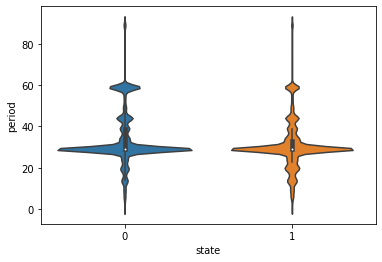

In [7]:
#⓷説明変数を考える（その2）
#期間の長さで変数を作る
data["deadline"]=pd.to_datetime(data["deadline"])
data["launched"]=pd.to_datetime(data["launched"])
date_delta=data["deadline"]-data["launched"]
#main_data["period"]=main_data["period"].days
data["period"]=date_delta.dt.days

data["period"].describe()
print(data["period"].value_counts())
sns.violinplot("state","period",data=data)


count    3.316750e+05
mean     4.151000e+04
std      1.108930e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64


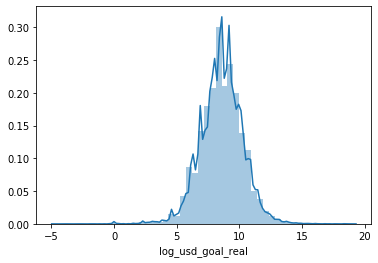

In [8]:
#⓷説明変数を考える（その3）
#usd_goal_realのヒストグラムを作成する
print(data["usd_goal_real"].describe())
#sns.distplot(data["usd_goal_real"])
#usd_goal_realで対数をとる
data["log_usd_goal_real"]=np.log(data["usd_goal_real"])
sns.distplot(data["log_usd_goal_real"])

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64
Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64
   Art  Comics  Crafts  Dance  Design  Fashion  Film & Video  Food  Games  \
0    0       0       0      0       0        0             0     0      0   
1    0       0       0      0       0        0             1     0      0   
2    0       0       0      0       0        0             1     0      0   
3    0     

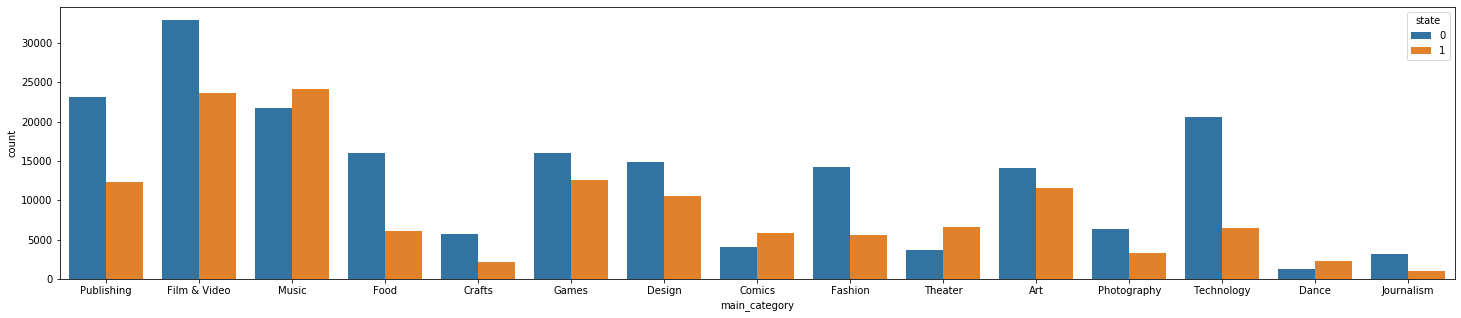

In [9]:
#⓷説明変数を考える(その４)
#categoryとmain_categoryの値を確認(159種類,15種類)
print(data["category"].value_counts())
print(data["main_category"].value_counts())

data1=pd.get_dummies(data["main_category"])
plt.figure(figsize = (25,5))
sns.countplot(data["main_category"],hue=data["state"])
print(data1.head())

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64
US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64
   currency_AUD  currency_CAD  currency_CHF  currency_DKK  currency_EUR  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
5             0            

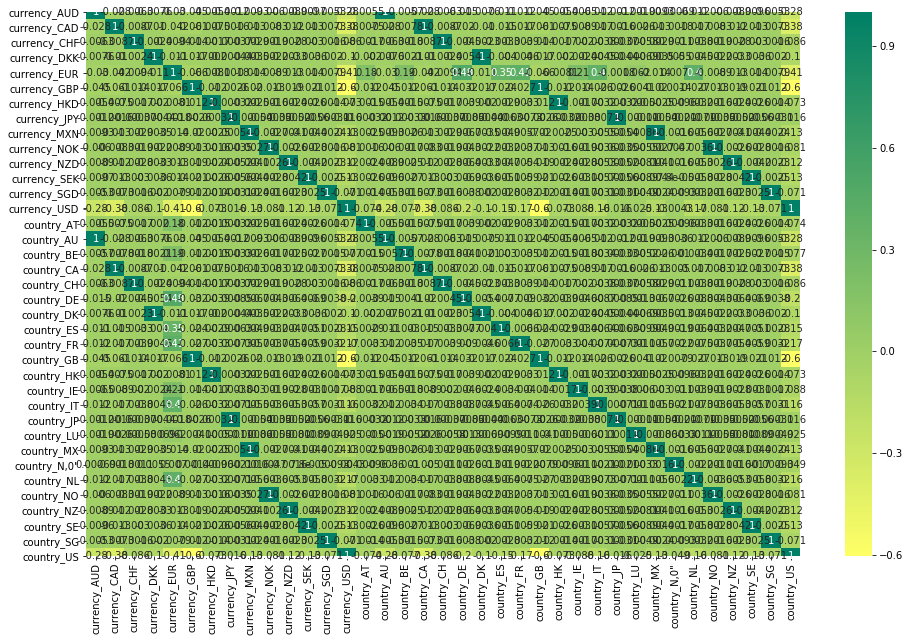

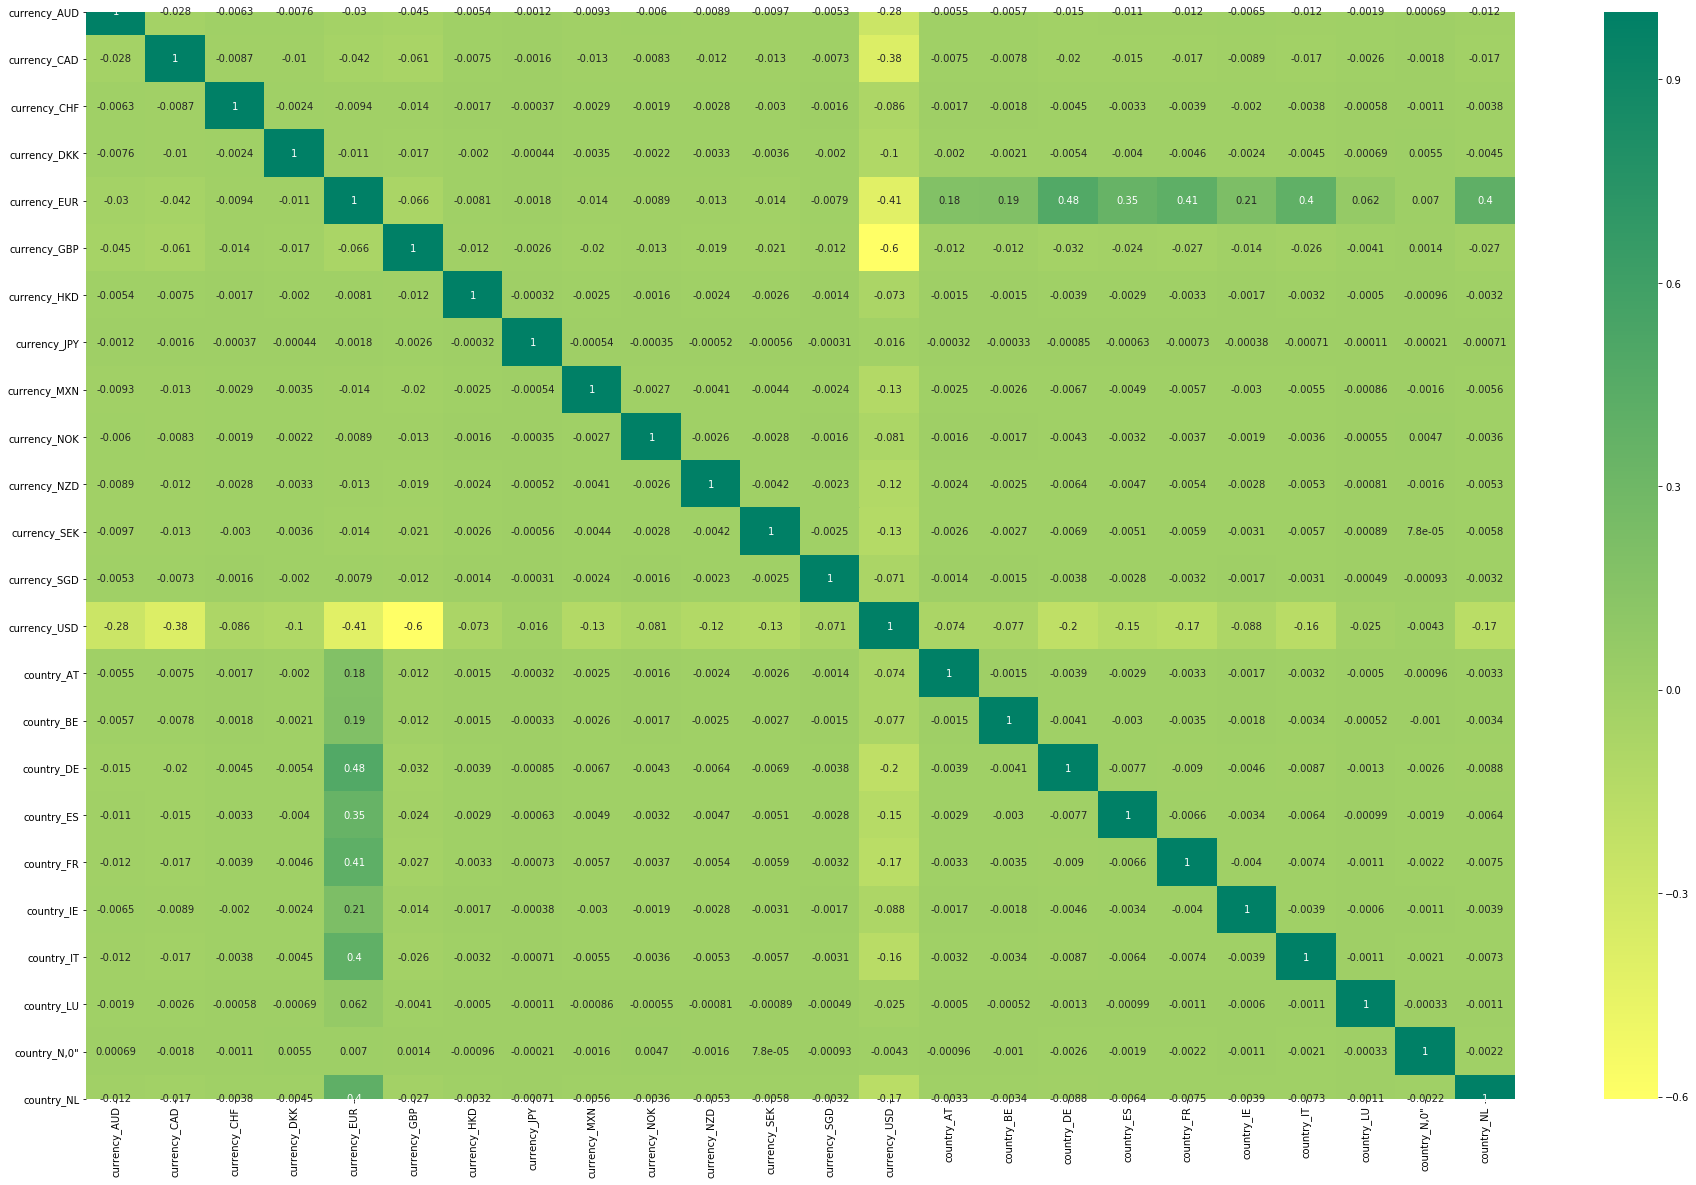

In [10]:
#⓷説明変数を考える(その5)
#currncyとcountryの関係を確認
print(data["currency"].value_counts())
print(data["country"].value_counts())

#currencyとcountryに相関があることを確認
data2=pd.get_dummies(data[["currency","country"]])
#data2=data2[["country_US","country_GB","currency_USD","currency_GBP"]]
print(data2.head())
plt.figure(figsize = (16,10))
sns.heatmap(data2.corr(),cmap="summer_r",annot=True)

#USDとGBPとAUDとCADのカントリーと通貨を無相関化する→ダミー変数同士の無相関化は意味がない
country=["country_US","country_GB","country_AU","country_CA","country_CH","country_DK","country_HK","country_JP","country_MX","country_NO","country_NZ","country_SE","country_SG"]
currency=["currency_USD","currency_GBP","currency_AUD","currency_CAD","currency_CHF","currency_DKK","currency_HKD","currency_JPY","currency_MXN","currency_NOK","currency_NZD","currency_SEK","currency_SGD"]
#data3=data2[["country_US","currency_USD","country_GB","currency_GBP",\"country_AU","currency_AUD","country_CA","currency_CAD"]]
"""
#  無相関化を行うための一連の処理
for co,cu in zip(country, currency):
    data3=data2[[co,cu]]
    cov = np.cov(data3, rowvar=0) # 分散・共分散を求める
    _, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
    data3_decorr = np.dot(S.T, data3.T).T #データを無相関化

    #  白色化を行うための一連の処理
    stdsc = StandardScaler()
    stdsc.fit(data3_decorr)
    data3_whitening  = stdsc.transform(data3_decorr) # 無相関化したデータに対して、さらに標準化
    print(co,cu,'相関係数: {:.3f}'.format(np.corrcoef(data3_whitening[:, 0], data3_whitening[:, 1])[0,1]))
    print(data3_decorr)
    data2[co] = data3_decorr[:,0]
    data2[cu] = data3_decorr[:,1]
"""
#相関が高いcountryをドロップする
data2=data2.drop(country,axis=1)
plt.figure(figsize = (32,20))
sns.heatmap(data2.corr(),cmap="summer_r",annot=True)

#一旦はcurrencyを採用し、弱小通貨は"other"にまとめるてダミー変数化する
#data.loc[(data["currency"]!='USD') & (data["currency"]!='GBP') & (data["currency"]!='EUR') & (data["currency"]!='CAD') & (data["currency"]!='AUD'),["currency"]]="others"
#print(data["currency"].value_counts())

In [11]:
#⓷説明変数を考える(その6)
#前月の成功率を変数化する
#launchedをyyyymm形式にして変数化する
#data["deadline"]=pd.to_datetime(data["deadline"])
#data["launched"]=pd.to_datetime(data["launched"])
#print(data["launched"].dt.year)
print(data["deadline"])
data["trend"]=data["deadline"].dt.strftime("%Y%m")
data_grouped=data.groupby("trend")
print(data_grouped["state"].count())
print(data_grouped["state"].sum())
data3=data_grouped["state"].sum()/data_grouped["state"].count()
print(data3)
data3_shift=data3.shift(+1)

#data3=pd.get_dummies(data["trend"])


#print(data["trend"])
#print(data["trend"].describe())

0        2015-10-09
1        2017-11-01
2        2013-02-26
3        2012-04-16
5        2016-04-01
            ...    
378654   2017-04-19
378657   2011-07-19
378658   2010-08-16
378659   2016-02-13
378660   2011-08-16
Name: deadline, Length: 331675, dtype: datetime64[ns]
trend
200905      11
200906      28
200907      59
200908      62
200909      79
          ... 
201709    3587
201710    3791
201711    3992
201712    3991
201801     220
Name: state, Length: 105, dtype: int64
trend
200905       3
200906      16
200907      38
200908      33
200909      41
          ... 
201709    1483
201710    1652
201711    1789
201712    1714
201801      86
Name: state, Length: 105, dtype: int64
trend
200905    0.272727
200906    0.571429
200907    0.644068
200908    0.532258
200909    0.518987
            ...   
201709    0.413437
201710    0.435769
201711    0.448146
201712    0.429466
201801    0.390909
Name: state, Length: 105, dtype: float64


In [12]:
#%%
#dataとdata1とdata2をconcatする
dataA=pd.concat([data,data1],axis=1)
dataA=pd.concat([dataA,data2],axis=1)
dataA=pd.merge(dataA,data3_shift,on="trend")
print(dataA.head(5))
dataA.info()
dataA=dataA.rename(columns={"state_x":"state","state_y":"success_rate_1monthago"})
dataA.info()


                                                name        category  \
0                    The Songs of Adelaide & Abullah          Poetry   
1  Legacy of Svarog | a Unique 3D Action RPG and ...     Video Games   
2                          David LaRocca: Star Spawn    Illustration   
3  Mooli London | Designer Camera & Tech Bag - Th...  Product Design   
4  Funky Grits - fast casual diner pairing music ...     Restaurants   

  main_category currency   deadline            launched  state_x country  \
0    Publishing      GBP 2015-10-09 2015-08-11 12:12:28        0      GB   
1         Games      USD 2015-10-30 2015-08-31 06:33:31        0      US   
2           Art      USD 2015-10-22 2015-09-21 14:44:46        1      US   
3        Design      GBP 2015-10-10 2015-09-04 16:33:23        1      GB   
4          Food      USD 2015-10-01 2015-09-03 17:32:07        0      US   

   usd_goal_real  name_length  ...  country_BE  country_DE country_ES  \
0        1533.95         31.0  ...   

In [13]:
#分析に使うデータ変数だけにする
#分析に使うデータ変数だけにする
#dataA=dataA.drop(["name","category","main_category",\"currency","deadline","launched","country","usd_goal_real","trend","others"],axis=1)
dataA=dataA.drop(["name","category","main_category",\
    "currency","deadline","launched","country","usd_goal_real","trend"],axis=1)
dataA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 331674
Data columns (total 44 columns):
state                     331675 non-null int64
name_length               331672 non-null float64
period                    331675 non-null int64
log_usd_goal_real         331675 non-null float64
Art                       331675 non-null uint8
Comics                    331675 non-null uint8
Crafts                    331675 non-null uint8
Dance                     331675 non-null uint8
Design                    331675 non-null uint8
Fashion                   331675 non-null uint8
Film & Video              331675 non-null uint8
Food                      331675 non-null uint8
Games                     331675 non-null uint8
Journalism                331675 non-null uint8
Music                     331675 non-null uint8
Photography               331675 non-null uint8
Publishing                331675 non-null uint8
Technology                331675 non-null uint8
Theater              

               state    name_length         period  log_usd_goal_real  \
count  331661.000000  331661.000000  331661.000000      331661.000000   
mean        0.403885      34.220210      32.955243           8.580903   
std         0.490676      15.961259      12.713234           1.673250   
min         0.000000       1.000000       0.000000          -4.605170   
25%         0.000000      21.000000      29.000000           7.600902   
50%         0.000000      33.000000      29.000000           8.517193   
75%         1.000000      48.000000      35.000000           9.615805   
max         1.000000      85.000000      91.000000          18.929673   

                 Art         Comics         Crafts          Dance  \
count  331661.000000  331661.000000  331661.000000  331661.000000   
mean        0.077299       0.029783       0.023572       0.010773   
std         0.267065       0.169990       0.151712       0.103233   
min         0.000000       0.000000       0.000000       0.000000 

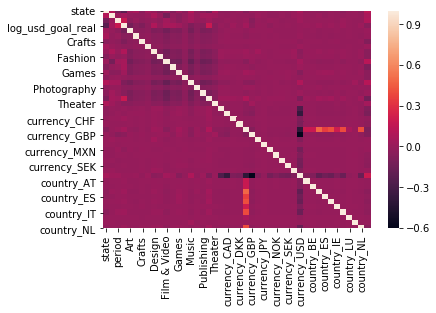

In [14]:
#⓸異常値、Null値、欠損値について考える
#欠損値はname_lengthの3件のみ、欠損値を含むレコードはdeleteする
dataA=dataA.dropna(how='any')

"""
ここまでで使いたい変数はそろえた！変数を変えるときは↑までを変える
"""
print(dataA.describe())
print(dataA.isnull().sum())
sns.heatmap(dataA.corr())
plt.show()

In [18]:
"""
↓ここからDAY１のやり直し
DAY1では変数がプロジェクト成功後に取得可能な変数も含んでしまっていたのでここで改めて
やってみる
"""
#ロジスティック回帰を行う
y=dataA["state"].values
X=dataA.drop("state",axis=1).values

#max_iter=学習の反復の最大回数
clf=SGDClassifier(loss="log",penalty='none',max_iter=10000, \
    fit_intercept=True,random_state=1234,tol=1e-3)
clf.fit(X,y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
#モデルの評価
y_pred=clf.predict(X)
print(f"対数尤度:{log_loss(y,y_pred):.3f}")
print(f"正答率:{accuracy_score(y,y_pred)*100:.3f}")
DAY1_accuracy=accuracy_score(y,y_pred)*100


対数尤度:11.846
正答率:65.703


In [20]:
#モデルを評価する（RECALL,ACCURACY,PRECISION)
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print(f'適合率（Precision） = {100 * precision[0]:.3f}%')
print(f'再現率（Recall） = {100 * recall[0]:.3f}%')
print(f'F1値（F1-score） = {100 * f1_score[0]:.3f}%')

DAY1_Precision=100 * precision[0]
DAY1_Recall=100 * recall[0]
DAY1_F1score=100 * f1_score[0]

適合率（Precision） = 67.387%
再現率（Recall） = 82.292%
F1値（F1-score） = 74.097%


In [21]:
#クロス表を作る
conf_mat=pd.DataFrame(confusion_matrix(y,y_pred),\
    index=['実際：×','実際：〇'],\
    columns=['予測:×','予測:〇'])
display(conf_mat)

"""
↑ここまでDAY１のやり直し
"""

,予測:×,予測:〇
実際：×,162697,35011
実際：〇,78740,55213


'\n↑ここまでDAY１のやり直し\n'

In [18]:
#⓹最後のフォールドアウト法のためのテストデータと訓練データの分割を行う
dataA_y=dataA["state"].values
dataA_x=dataA.drop(["state"],axis=1).values
test_size=0.2
dataA_x_train,dataA_x_test,dataA_y_train,dataA_y_test= \
    train_test_split(dataA_x,dataA_y,test_size=test_size,random_state=1234)

"""
dataA_x_train,,dataA_y_train→さらにクロスバリデーションへ
dataA_x_test,dataA_y_test→ホールドアウト法
"""

'\ndataA_x_train,,dataA_y_train→さらにクロスバリデーションへ\ndataA_x_test,dataA_y_test→ホールドアウト法\n'

In [23]:
#⓺グリッドサーチでL2正則化のペナルティ項の係数を探す。ロジスティック回帰。
#dataA_x_train, dataA_y_trainを使う

model=SGDClassifier(random_state=1234)
parameters={'penalty':['l2', 'l1', 'elasticnet'],'alpha':[1,0.1,0.01,1e-3,1e-4,1e-5]}
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(dataA_x_train, dataA_y_train)
print(clf.best_params_, clf.best_score_)

{'alpha': 0.001, 'penalty': 'elasticnet'} 0.6476059820297896


In [24]:
#⓻交差検証法を
# ロジスティック回帰モデルで
# dataA_x_train,,dataA_y_trainでおこなう

n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_accuracy_test = 0
cross_valid_accuracy_learning = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_index,test_index in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(dataA_x_train, dataA_y_train):
    #print(X[train_index],y[train_index])
    X_train,y_train=dataA_x_train[train_index],dataA_y_train[train_index]
    X_test,y_test=dataA_x_train[test_index],dataA_y_train[test_index]

    #データの標準化を行う※※※    
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    #plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
    X_test_stand = stdsc.transform(X_test)
    #plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

    # 学習用データを使ってロジスティック回帰モデルを学習
    #reg=LinearRegression(fit_intercept=True)
    clf=SGDClassifier(\
        loss="log",\
        penalty='elasticnet',\
        alpha=0.001, \
        max_iter=10000, \
        fit_intercept=True,random_state=1234,tol=1e-3)
    clf.fit(X_train_stand,y_train)

    # 学習データに対する予測を実行
    y_train_predict=clf.predict(X_train_stand)

    # 学習データに対するAccuracyを計算
    
    #print(f"対数尤度:{log_loss(y_train,y_train_predict):.3f}")
    accuracy_learning=accuracy_score(y_train,y_train_predict)*100


    # テストデータに対する予測を実行
    y_predict_test=clf.predict(X_test_stand)

    # テストデータに対するMAEを計算
    
    #mae=mean_absolute_error(y_test,y_predict_test)
    accuracy_test=accuracy_score(y_test,y_predict_test)*100
    print(f"{split_num}回目:Accuracy_learning{accuracy_learning:.3f}")
    print(f"{split_num}回目:Accuracy_test{accuracy_test:.3f}")
    #後で平均を取るためにAccuracyを加算
    cross_valid_accuracy_learning+=accuracy_learning
    cross_valid_accuracy_test+=accuracy_test
    split_num += 1
    print(split_num)

1回目:Accuracy_learning65.807
1回目:Accuracy_test65.498
2
2回目:Accuracy_learning65.755
2回目:Accuracy_test65.575
3
3回目:Accuracy_learning65.682
3回目:Accuracy_test66.008
4
4回目:Accuracy_learning65.863
4回目:Accuracy_test65.900
5
5回目:Accuracy_learning65.824
5回目:Accuracy_test65.829
6


In [25]:
#accuracyの平均をとる
final_accuracy_learning=cross_valid_accuracy_learning/n_split
final_accuracy_test=cross_valid_accuracy_test/n_split
print(f"cross varidation accuracy:{final_accuracy_learning:.3f}")
print(f"cross varidation accuracy:{final_accuracy_test:.3f}")


cross varidation accuracy:65.786
cross varidation accuracy:65.762


In [26]:
#⓼グリッドサーチ法で最適とわかったモデルをクロスバリデーションで評価した後、
# ホールドアウト法を用いてdataA_x_trainで学習しdataA_y_trainで汎化誤差を測って
#予測モデルを確定させる

#標準化を実装 
stdsc = StandardScaler()
dataA_x_train_stand = stdsc.fit_transform(dataA_x_train)
print(dataA_x_train_stand)
#plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
dataA_x_test_stand = stdsc.transform(dataA_x_test)
#plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）


# 学習用データを使って線形回帰モデルを学習
clf=SGDClassifier(loss="log",penalty='l2',alpha=0.001, \
    max_iter=10000,fit_intercept=True, \
        random_state=1234,tol=1e-3)
clf.fit(dataA_x_train_stand,dataA_y_train)

# 学習用データに対する予測を実行
y_predict_train=clf.predict(dataA_x_train_stand)

# 学習データに対するAccuracyを計算（訓練誤差の評価）
accuracy=accuracy_score(dataA_y_train,y_predict_train)
print(f"Accuracy:{accuracy*100:.3f}")

# テストデータに対する予測を実行
y_predict_test=clf.predict(dataA_x_test_stand)

# テストデータに対するAccuracyを計算（汎化誤差の評価）
accuracy_test=accuracy_score(dataA_y_test,y_predict_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(dataA_y_test,y_predict_test)
print(f"Accuracy_test:{accuracy_test*100:.3f}")
print(f'適合率（Precision） = {100 * precision[0]:.3f}%')
print(f'再現率（Recall） = {100 * recall[0]:.3f}%')
print(f'F1値（F1-score） = {100 * f1_score[0]:.3f}%')

[[-0.38847799 -0.31103221 -0.75755796 ... -0.02576374 -0.08499451
   1.40366023]
 [ 0.3010135  -0.31103221 -0.75755796 ... -0.02576374 -0.08499451
   1.42478355]
 [ 1.49195333 -0.31103221  0.87371732 ... -0.02576374 -0.08499451
  -1.20054875]
 ...
 [ 1.3039102   0.63255283  1.03165464 ... -0.02576374 -0.08499451
  -0.97449032]
 [ 0.7397808  -0.07513595 -0.64866571 ... -0.02576374 -0.08499451
   1.07345502]
 [ 0.48905663 -0.07513595  1.75073202 ... -0.02576374 -0.08499451
  -1.34660615]]
Accuracy:65.717
Accuracy_test:65.559
適合率（Precision） = 67.285%
再現率（Recall） = 81.882%
F1値（F1-score） = 73.869%


In [27]:
print(f"DAY1_accuracy:{DAY1_accuracy}")
print(f"DAY1_Precision:{DAY1_Precision}")
print(f"DAY1_Recall:{DAY1_Recall}")
print(f"DAY1_F1score:{DAY1_F1score}")

"""
訓練誤差、汎化誤差ともに低く、未学習の状態と考えられる
DAY１と比較しても特段モデルの改善は図れなかった。

"""

DAY1_accuracy:65.70263009518756
DAY1_Precision:67.38693737910924
DAY1_Recall:82.29156129241103
DAY1_F1score:74.09716608409524


'\n訓練誤差、汎化誤差ともに低く、未学習の状態と考えられる\nDAY１と比較しても特段モデルの改善は図れなかった。\n\n'

In [28]:
"""
↓SVMを1000個のデータでやってみる(dataB)
"""
dataB=dataA.sample(n=1000,random_state=1234)
#⓹最後のフォールドアウト法のためのテストデータと訓練データの分割を行う
dataB_y=dataB["state"].values
dataB_x=dataB.drop(["state"],axis=1).values
test_size=0.2
dataB_x_train,dataB_x_test,dataB_y_train,dataB_y_test= \
    train_test_split(dataB_x,dataB_y,test_size=test_size,random_state=1234)

"""
dataA_x_train,,dataA_y_train→さらにクロスバリデーションへ
dataA_x_test,dataA_y_test→ホールドアウト法
"""

'\ndataA_x_train,,dataA_y_train→さらにクロスバリデーションへ\ndataA_x_test,dataA_y_test→ホールドアウト法\n'

In [29]:
#⑨グリッドサーチでSVMのペナルティ項の係数を探す。
#データ数は1000ぐらいに抑えてみる
parameters = {'kernel':['linear', 'rbf'], 'C':[1,2,3,4,5]} # ここを編集する
model = SVC(gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(dataB_x_train, dataB_y_train)
print(clf.best_params_, clf.best_score_)

{'C': 5, 'kernel': 'linear'} 0.6375


In [15]:
"""
ここからDAY3の課題
dataAに入っているデータをもう一度精査してみる
"""
#print(dataA.describe())
#フィルター法(相関係数が0.8以上の変数の片側を除去)→08以上はなかった
#フィルター法でDROPする変数なし
#sns.heatmap(dataA.corr(),cmap="summer_r",annot=True)
print(abs(dataA.corr())>0.8)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = dataA.columns
    for i in range(0, dataA.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = dataA.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(dataA)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dataA, 3))



                        state  name_length  period  log_usd_goal_real    Art  \
state                    True        False   False              False  False   
name_length             False         True   False              False  False   
period                  False        False    True              False  False   
log_usd_goal_real       False        False   False               True  False   
Art                     False        False   False              False   True   
Comics                  False        False   False              False  False   
Crafts                  False        False   False              False  False   
Dance                   False        False   False              False  False   
Design                  False        False   False              False  False   
Fashion                 False        False   False              False  False   
Film & Video            False        False   False              False  False   
Food                    False        Fal

currency_GBP  currency_USD    0.602934
currency_EUR  country_DE      0.480634
              country_FR      0.411039
dtype: float64


In [31]:
"""
ステップワイズ法
dataA_x_train,,dataA_y_train
"""
# estimatorにモデルをセット
# 今回は回帰問題であるためロジスティック回帰を使用
estimator = SGDClassifier(loss="log",penalty='none',\
    max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='accuracy')
y= dataA_y_train
X= dataA_x_train

# fitで特徴選択を実行
rfecv.fit(X, y)


RFECV(cv=10,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=10000, n_iter_no_change=5, n_jobs=None,
                              penalty='none', power_t=0.5, random_state=1234,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


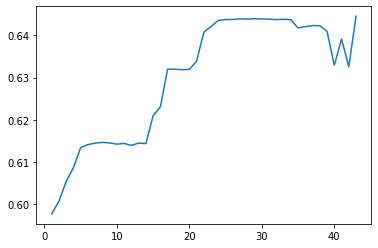

   name_length  period  log_usd_goal_real  Art  Comics  Crafts  Dance  Design  \
0         31.0      58           7.335601    0       0       0      0       0   
1         60.0      59          10.819778    0       0       0      0       0   
2         25.0      30           6.476972    1       0       0      0       0   
3         55.0      35          10.050380    0       0       0      0       1   
4         60.0      27          11.512925    0       0       0      0       0   

   Fashion  Film & Video  ...  country_BE  country_DE  country_ES  country_FR  \
0        0             0  ...           0           0           0           0   
1        0             0  ...           0           0           0           0   
2        0             0  ...           0           0           0           0   
3        0             0  ...           0           0           0           0   
4        0             0  ...           0           0           0           0   

   country_IE  country_IT 

'\n↑ここまでステップワイズ法\nすべての変数を使うときが最もaccuracyが高いと判定\n\n'

In [32]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx
# 削除してもよい特徴の名前を取得する
dataC=dataA.drop("state",axis=1)
remove_feature = dataC.columns[remove_idx]
remove_feature
# drop関数で特徴を削除

dataC = dataC.drop(remove_feature, axis=1)
print(dataC.head(5))

"""
↑ここまでステップワイズ法
すべての変数を使うときが最もaccuracyが高いと判定

"""

In [16]:
"""
↓埋め込み法
dataA_x_train,,dataA_y_train
"""
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-3)

Index(['Art', 'currency_JPY', 'currency_SGD', 'country_DE'], dtype='object')


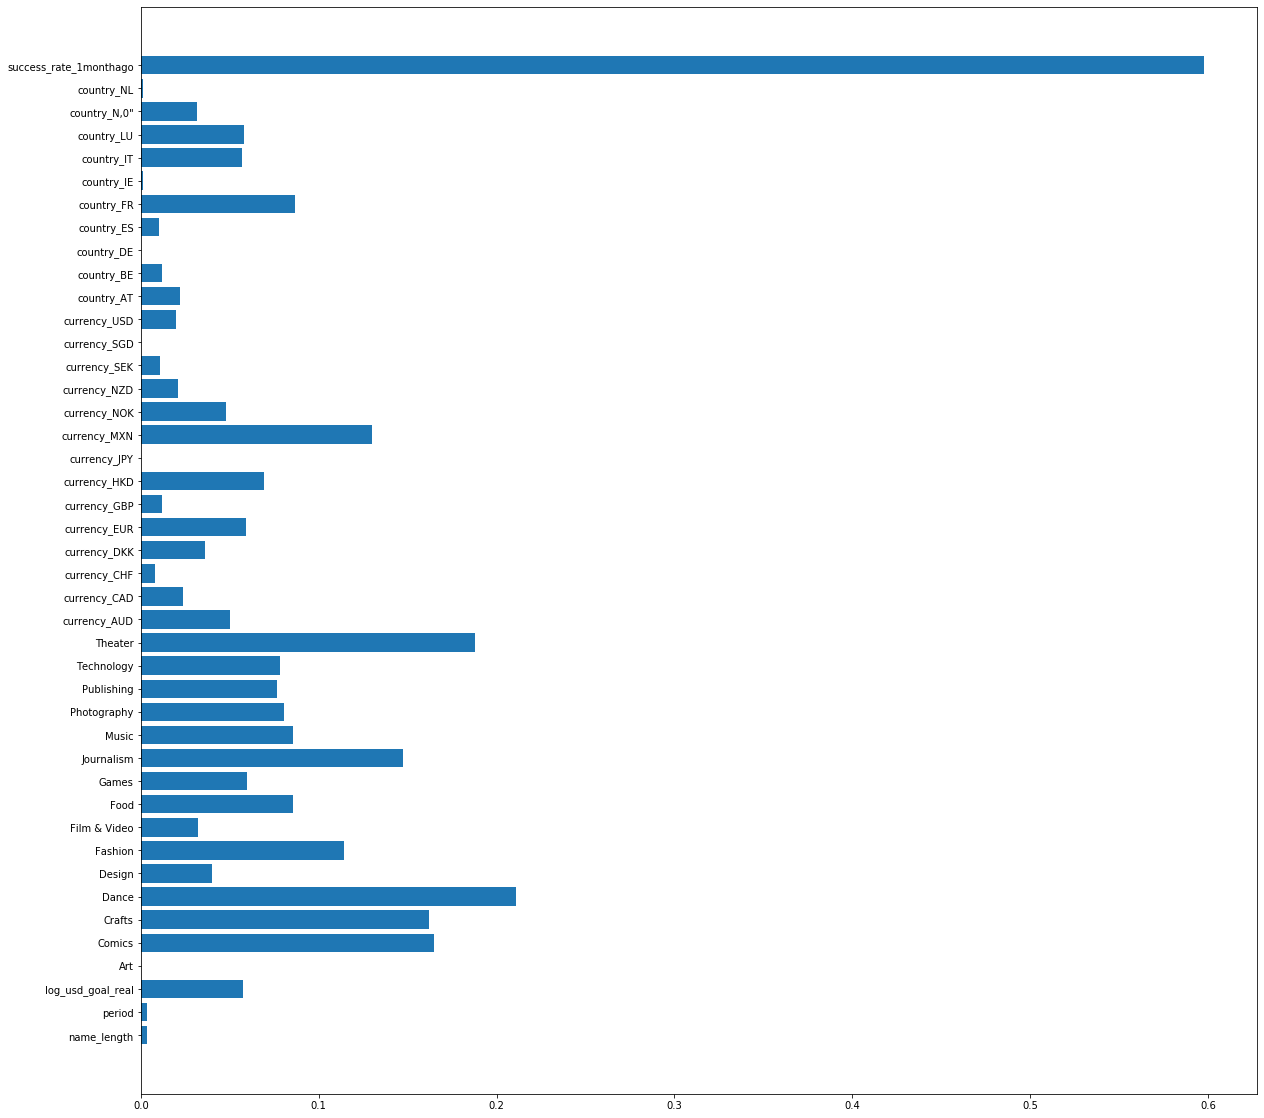

'\n↑ここまで埋め込み法\n'

In [19]:
#%%
X=dataA_x_train
y=dataA_y_train
# fitで特徴選択を実行
sfm.fit(X, y)
# %%
dataB=dataA.drop(["state"],axis=1)
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
print(dataB.columns[removed_idx])
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef
# 係数を棒グラフで表示
plt.figure(figsize = (20,20))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=dataB.columns.values)
plt.show()

"""
↑ここまで埋め込み法
"""




In [20]:
"""
ここで特徴選択後のdataBを作る
"""
print(dataB.columns[removed_idx])
dataB=dataB.drop(dataB.columns[removed_idx],axis=1)
print(dataB.info())

Index(['Art', 'currency_JPY', 'currency_SGD', 'country_DE'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331661 entries, 0 to 331663
Data columns (total 39 columns):
name_length               331661 non-null float64
period                    331661 non-null int64
log_usd_goal_real         331661 non-null float64
Comics                    331661 non-null uint8
Crafts                    331661 non-null uint8
Dance                     331661 non-null uint8
Design                    331661 non-null uint8
Fashion                   331661 non-null uint8
Film & Video              331661 non-null uint8
Food                      331661 non-null uint8
Games                     331661 non-null uint8
Journalism                331661 non-null uint8
Music                     331661 non-null uint8
Photography               331661 non-null uint8
Publishing                331661 non-null uint8
Technology                331661 non-null uint8
Theater                   331661 non-nul

In [21]:
"""
特徴選択後のdataBでホールドアウト法
"""
dataB_y=dataA["state"].values
print(dataB_y)
dataB_x=dataB.values
print(dataB_x)
test_size=0.2
dataB_x_train,dataB_x_test,dataB_y_train,dataB_y_test= \
    train_test_split(dataB_x,dataB_y,test_size=test_size,random_state=1234)

"""
dataB_x_train,,dataB_y_train→さらにクロスバリデーションへ
dataB_x_test,dataB_y_test→ホールドアウト法
"""

[0 0 1 ... 0 1 1]
[[31.         58.          7.33560139 ...  0.          0.
   0.30668605]
 [60.         59.         10.81977828 ...  0.          0.
   0.30668605]
 [25.         30.          6.47697236 ...  0.          0.
   0.30668605]
 ...
 [25.         23.          5.52146092 ...  0.          0.
   0.27272727]
 [13.         32.          6.90775528 ...  0.          0.
   0.27272727]
 [15.         30.          6.2146081  ...  0.          0.
   0.27272727]]


'\ndataB_x_train,,dataB_y_train→さらにクロスバリデーションへ\ndataB_x_test,dataB_y_test→ホールドアウト法\n'

In [ ]:
"""
決定木
"""
X_train = dataB_x_train
y_train = dataB_y_train
#⓺グリッドサーチでパラメータを決定
#dataA_x_train, dataA_y_trainを使う

model=DecisionTreeClassifier(criterion="gini",random_state=1234)
parameters={'max_depth':[3,4,5,6,7,8,9,10],\
        'min_samples_split':[3,4,5,6,7,8,9,10],\
        'min_samples_leaf':[3,4,5,6,7,8,9,10]}
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)
"""

決定木...
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 3} 0.614556322740155
"""

[[39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 [23.         29.         10.59663473 ...  0.          0.
   0.46312518]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [0 0 0 ... 1 1 0]
score= 0.6710339109214084
score= 1.0
1回目:Accuracy_learning0.671
1回目:Accuracy_test1.000
2
[8.76063216e-02 2.00704697e-01 4.07225199e-01 2.28266176e-02
 1.38547832e-03 4.71618828e-03 6.53055276e-03 1.89570243e-02
 1.01263952e-02 3.30083167e-03 1.28132449e-02 4.47871179e-04
 2.83593431e-02 0.00000000e+00 2.25814550e-02 8.71698459e-03
 2.74816640e-02 1.39125580e-04 6.13847033e-04 3.14101128e-04
 1.95070009e-04 2.03529300e-03 3.45514635e-03 0.00000000e+00
 9.68313676e-04 0.00000000e+00 0.00000000e+00 1.73200998e-05
 5.19046630e-03 0.0000

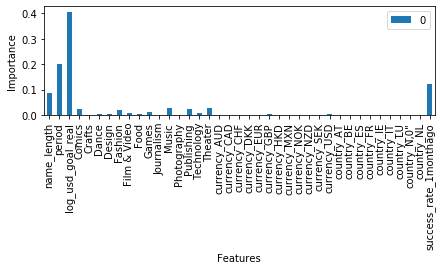

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 ...
 [53.         29.          9.39266193 ...  0.          0.
   0.27714374]
 [ 9.         59.          9.90348755 ...  0.          0.
   0.44893832]
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]] [1 0 0 ... 1 0 1]
score= 0.6666431108724123
score= 1.0
2回目:Accuracy_learning0.667
2回目:Accuracy_test1.000
3
[9.17861569e-02 1.65539304e-01 4.13487739e-01 2.42152418e-02
 1.45289786e-04 5.01691974e-03 1.06087578e-02 1.97736323e-02
 9.78574608e-03 4.42831466e-03 1.48536864e-02 0.00000000e+00
 3.74041790e-02 1.44028853e-03 1.90571641e-02 1.34466123e-02
 3.36045722e-02 5.96335291e-04 1.38564188e-03 0.00000000e+00
 3.61352386e-04 2.41432148e-03 2.58343886e-03 3.14871410e-04
 1.39611411e-03 0.00000000e+00 0.00000000e+00 6.81362492e-05
 5.25014264e-03 0.0000

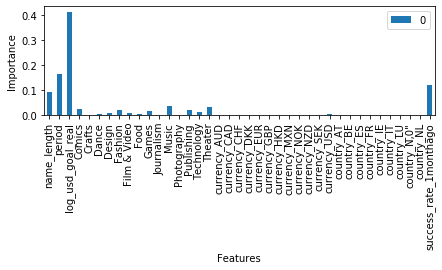

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [23.         29.         10.59663473 ...  0.          0.
   0.46312518]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 1 1 0]
score= 0.6667891567967889
score= 1.0
3回目:Accuracy_learning0.667
3回目:Accuracy_test1.000
4
[9.37957119e-02 1.68677233e-01 4.15839143e-01 2.43181632e-02
 2.96453153e-03 1.11391464e-02 6.41580699e-03 1.83957556e-02
 1.05846175e-02 2.80130584e-03 1.41988466e-02 1.97711380e-04
 3.72861245e-02 1.91933632e-03 1.17567479e-02 1.26298102e-02
 3.16118033e-02 3.42891928e-04 9.53431608e-04 0.00000000e+00
 1.38218423e-04 1.09044802e-03 5.27527389e-03 2.06720872e-04
 6.25407030e-04 3.78245217e-05 1.08473420e-04 4.42589306e-05
 5.41043101e-03 0.0000

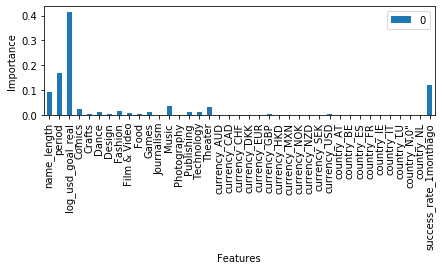

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 1 1 0]
score= 0.6689437160503715
score= 1.0
4回目:Accuracy_learning0.669
4回目:Accuracy_test1.000
5
[1.01168808e-01 1.67946962e-01 4.01998193e-01 2.41830498e-02
 9.50021381e-04 9.70697475e-03 6.39359048e-03 1.93244283e-02
 1.47834365e-02 1.60329499e-03 1.65469058e-02 3.47389494e-04
 3.18810428e-02 9.69634542e-04 2.37643663e-02 9.00527735e-03
 2.90204616e-02 6.48333548e-04 8.70381131e-04 2.65933418e-05
 2.17543089e-04 2.30543286e-03 3.23136990e-03 5.07789720e-04
 0.00000000e+00 0.00000000e+00 2.63008525e-04 4.47327206e-04
 5.82972679e-03 0.0000

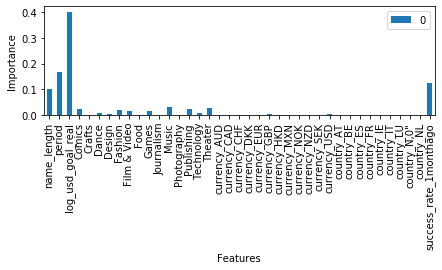

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 [56.         30.          9.21034037 ...  0.          0.
   0.48582286]
 ...
 [ 9.         59.          9.90348755 ...  0.          0.
   0.44893832]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 0 1 0]
score= 0.6671205061645223
score= 1.0
5回目:Accuracy_learning0.667
5回目:Accuracy_test1.000
6
[9.16024542e-02 1.77110699e-01 4.12368656e-01 2.31835715e-02
 1.40714316e-03 5.44388910e-03 6.48068294e-03 1.14435331e-02
 8.97232222e-03 5.26623598e-03 1.54352619e-02 5.25571821e-04
 3.76878615e-02 9.67454726e-04 1.92019892e-02 1.14635420e-02
 3.66453156e-02 1.18830081e-03 6.17039960e-04 1.34081941e-04
 2.14142275e-04 1.44931164e-03 4.16500033e-03 1.08632246e-04
 1.31899423e-03 0.00000000e+00 0.00000000e+00 7.49352580e-05
 4.11923483e-03 0.0000

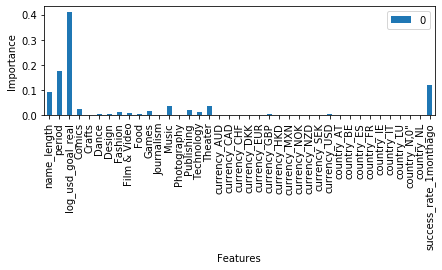

In [22]:
#⓻交差検証法を
# 決定偽モデルで
# dataB_x_train,,dataB_y_trainでおこなう

n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_score_test = 0
cross_valid_score_learning = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_index,test_index in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(dataB_x_train,dataB_y_train):
    print(dataB_x_train[train_index],dataB_y_train[train_index])
    #x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
    X_train,y_train=dataB_x_train[train_index],dataB_y_train[train_index]
    X_test,y_test=dataB_x_train[test_index],dataB_y_train[test_index]

    #データの標準化を行う※※※    
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    #plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
    X_test_stand = stdsc.transform(X_test)
    #plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

    # 学習用データを使って決定木モデルを学習
    #reg=LinearRegression(fit_intercept=True)

    clf = DecisionTreeClassifier(criterion="gini", max_depth=10,\
     min_samples_split=4, min_samples_leaf=3, random_state=1234)
    clf = clf.fit(X_train_stand, y_train)
    print("score=", clf.score(X_train_stand, y_train))

    # テストデータに対する予測を実行
    y_predict_test=clf.predict(X_test_stand)

    # テストデータに対するスコアを計算
    print("score=", clf.score(X_test_stand, y_predict_test))
    #mae=mean_absolute_error(y_test,y_predict_test)
    accuracy_test=clf.score(X_test_stand, y_predict_test)*100
    print(f"{split_num}回目:Accuracy_learning{clf.score(X_train_stand, y_train):.3f}")
    print(f"{split_num}回目:Accuracy_test{ clf.score(X_test_stand, y_predict_test):.3f}")
    #後で平均を取るためにAccuracyを加算
    cross_valid_score_learning+=clf.score(X_train_stand, y_train)
    cross_valid_score_test+=clf.score(X_test_stand, y_predict_test)
    split_num += 1
    print(split_num)

    # 説明変数の重要度を出力する
    # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
    print(clf.feature_importances_)
    pd.DataFrame(clf.feature_importances_, index=dataB.columns).plot.bar(figsize=(7,2))
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.show()

In [31]:
#accuracyの平均をとる
final_score_learning=cross_valid_score_learning/n_split
final_score_test=cross_valid_score_test/n_split
print(f"cross varidation accuracy:{final_score_learning:.3f}")
print(f"cross varidation accuracy:{final_score_test:.3f}")
"""
DAY2のaccuracy=0.657のため1%程の改善が見られた。
決定木のスコア0.668
"""

cross varidation accuracy:0.664
cross varidation accuracy:1.000


'\n決定木のスコア0.668\n'

In [ ]:
"""
ランダムフォレスト
"""
X_train = dataB_x_train
y_train = dataB_y_train
#⓺グリッドサーチでパラメータを決定
#dataA_x_train, dataA_y_trainを使う

model=RandomForestClassifier(n_estimators=10, \
                    criterion="gini",\
                    random_state=1234)
parameters={'max_depth':[3,4,5,6,7,8,9,10],\
        'min_samples_split':[3,4,5,6,7,8,9,10],\
        'min_samples_leaf':[3,4,5,6,7,8,9,10]}
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

[[39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 [23.         29.         10.59663473 ...  0.          0.
   0.46312518]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [0 0 0 ... 1 1 0]
score= 0.6640048619159341
score= 1.0
1回目:Accuracy_learning0.664
1回目:Accuracy_test1.000
2
[1.21118455e-01 1.49294225e-01 3.39103993e-01 2.99724051e-02
 3.99139442e-03 8.90690919e-03 2.53994392e-03 2.33612850e-02
 8.32999274e-03 1.59787997e-02 1.41916243e-02 3.21090792e-03
 3.49703462e-02 1.76833371e-03 1.49036223e-02 3.87777630e-02
 4.00386690e-02 2.82952902e-03 1.43547255e-03 1.62073400e-04
 2.93313177e-04 8.87522272e-03 2.15959717e-03 3.06960675e-04
 1.49833441e-03 1.71921824e-04 4.21520393e-04 3.52996457e-04
 9.71731714e-03 8.3528

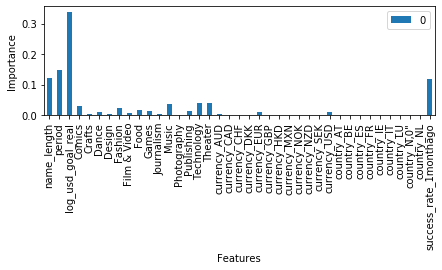

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 ...
 [53.         29.          9.39266193 ...  0.          0.
   0.27714374]
 [ 9.         59.          9.90348755 ...  0.          0.
   0.44893832]
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]] [1 0 0 ... 1 0 1]
score= 0.6590769897579407
score= 1.0
2回目:Accuracy_learning0.659
2回目:Accuracy_test1.000
3
[1.02704444e-01 1.64282144e-01 3.30359673e-01 3.05476525e-02
 3.54281959e-03 8.84611557e-03 2.98103665e-03 1.62503044e-02
 4.49987203e-03 1.45882631e-02 9.15769324e-03 4.18314696e-03
 3.67746998e-02 2.93463875e-03 1.96996546e-02 3.76232629e-02
 4.51178152e-02 2.53651237e-03 1.60005330e-03 1.52955299e-04
 2.24346091e-04 8.30629228e-03 3.03324945e-03 3.54909196e-05
 8.62173127e-04 1.44254197e-04 1.85635256e-04 3.10931392e-04
 6.51837498e-03 2.5721

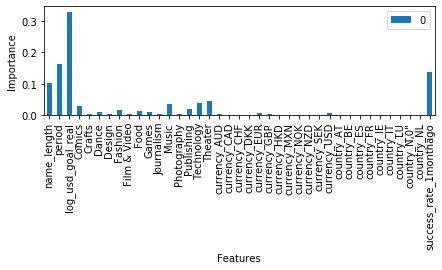

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [23.         29.         10.59663473 ...  0.          0.
   0.46312518]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 1 1 0]
score= 0.6647916254440267
score= 1.0
3回目:Accuracy_learning0.665
3回目:Accuracy_test1.000
4
[9.03723963e-02 1.58723856e-01 3.54715588e-01 2.73029189e-02
 6.19329642e-03 1.25771263e-02 4.56543694e-03 1.63439943e-02
 7.68593499e-03 2.12742122e-02 1.24217428e-02 4.01281577e-03
 4.63354335e-02 2.56042184e-03 1.78524636e-02 4.08108176e-02
 4.07232844e-02 2.51032705e-03 2.01828416e-03 1.28281102e-04
 3.77192857e-04 7.03781100e-03 3.11734734e-03 1.32883279e-04
 1.28626544e-03 1.85086042e-04 3.16873228e-04 3.59171406e-04
 4.48918953e-03 8.8311

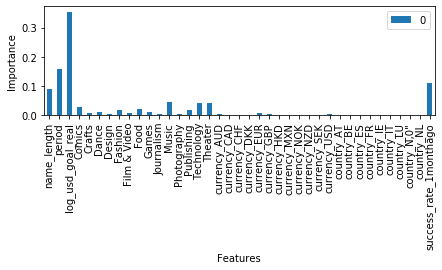

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 1 1 0]
score= 0.665466897198287
score= 1.0
4回目:Accuracy_learning0.665
4回目:Accuracy_test1.000
5
[1.00097378e-01 1.75671381e-01 3.41966120e-01 2.86549470e-02
 5.25355190e-03 9.03155289e-03 2.21795448e-03 2.24460114e-02
 4.89658595e-03 1.95700826e-02 1.15365056e-02 2.19923422e-03
 3.24544829e-02 2.23926881e-03 1.31023221e-02 4.59378783e-02
 4.28699182e-02 2.00950431e-03 2.07666673e-03 7.61017837e-05
 1.71756064e-04 7.61130832e-03 2.98263921e-03 4.56225681e-04
 1.09398416e-03 5.56655260e-05 2.79765379e-04 3.44794932e-04
 6.03568344e-03 1.23964

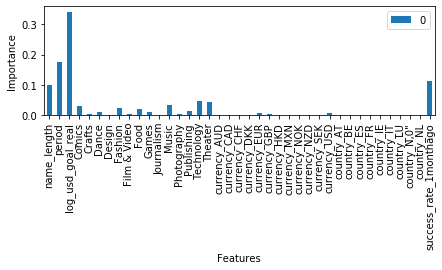

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 [56.         30.          9.21034037 ...  0.          0.
   0.48582286]
 ...
 [ 9.         59.          9.90348755 ...  0.          0.
   0.44893832]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 0 1 0]
score= 0.6644257359973241
score= 1.0
5回目:Accuracy_learning0.664
5回目:Accuracy_test1.000
6
[1.14335824e-01 1.81764348e-01 3.23076894e-01 2.38710816e-02
 3.41516758e-03 8.43966128e-03 4.24313169e-03 1.75322123e-02
 1.11035114e-02 1.56695507e-02 9.46680021e-03 4.14344134e-03
 3.07208014e-02 1.88816167e-03 1.11124573e-02 4.82316434e-02
 4.44111874e-02 2.86090860e-03 1.26120284e-03 1.16251976e-04
 2.39492693e-04 9.05523229e-03 4.08040894e-03 4.21173065e-04
 1.17282969e-03 1.63417031e-04 4.53865519e-04 2.69888275e-04
 4.32770306e-03 5.3238

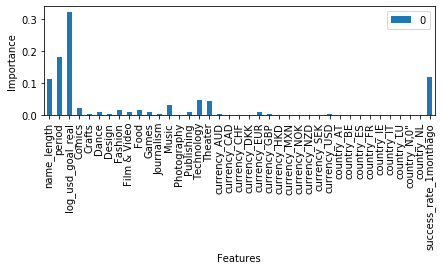

'\nランダムフォレストのスコア0.6117334016\n'

In [28]:
#⓻交差検証法を
# 決定偽モデルで
# dataB_x_train,,dataB_y_trainでおこなう

n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_score_test = 0
cross_valid_score_learning = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_index,test_index in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(dataB_x_train,dataB_y_train):
    print(dataB_x_train[train_index],dataB_y_train[train_index])
    #x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
    X_train,y_train=dataB_x_train[train_index],dataB_y_train[train_index]
    X_test,y_test=dataB_x_train[test_index],dataB_y_train[test_index]

    #データの標準化を行う※※※    
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    #plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
    X_test_stand = stdsc.transform(X_test)
    #plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

    # 学習用データを使って決定木モデルを学習
    #reg=LinearRegression(fit_intercept=True)

    clf = RandomForestClassifier(n_estimators=10,\
                                criterion="gini", max_depth=10,\
                                min_samples_split=4, \
                                min_samples_leaf=3, \
                                random_state=1234)
    clf = clf.fit(X_train_stand, y_train)
    print("score=", clf.score(X_train_stand, y_train))

    # テストデータに対する予測を実行
    y_predict_test=clf.predict(X_test_stand)

    # テストデータに対するスコアを計算
    print("score=", clf.score(X_test_stand, y_predict_test))
    #mae=mean_absolute_error(y_test,y_predict_test)
    accuracy_test=clf.score(X_test_stand, y_predict_test)*100
    print(f"{split_num}回目:Accuracy_learning{clf.score(X_train_stand, y_train):.3f}")
    print(f"{split_num}回目:Accuracy_test{ clf.score(X_test_stand, y_predict_test):.3f}")
    #後で平均を取るためにAccuracyを加算
    cross_valid_score_learning+=clf.score(X_train_stand, y_train)
    cross_valid_score_test+=clf.score(X_test_stand, y_predict_test)
    split_num += 1
    print(split_num)

    # 説明変数の重要度を出力する
    # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
    print(clf.feature_importances_)
    pd.DataFrame(clf.feature_importances_, index=dataB.columns).plot.bar(figsize=(7,2))
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.show()



In [30]:
#accuracyの平均をとる
final_score_learning=cross_valid_score_learning/n_split
final_score_test=cross_valid_score_test/n_split
print(f"cross varidation accuracy:{final_score_learning:.3f}")
print(f"cross varidation accuracy:{final_score_test:.3f}")
"""
DAY2のaccuracy=0.657のため1%程の改善が見られた。
ランダムフォレストのスコア0.664
"""

cross varidation accuracy:0.664
cross varidation accuracy:1.000


'\nランダムフォレストのスコア0.664\n'

In [ ]:
"""
アダブースト
"""
X_train = dataB_x_train
y_train = dataB_y_train
#⓺グリッドサーチでパラメータを決定
#dataA_x_train, dataA_y_trainを使う

model= AdaBoostClassifier(DecisionTreeClassifier(random_state=1234,
                                                criterion="gini"),
                                           n_estimators=10, random_state=1234
parameters={'max_depth':[3,4,5,6,7,8,9,10],\
        'min_samples_split':[3,4,5,6,7,8,9,10],\
        'min_samples_leaf':[3,4,5,6,7,8,9,10]}
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

[[39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 [23.         29.         10.59663473 ...  0.          0.
   0.46312518]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [0 0 0 ... 1 1 0]
score= 0.6774363757997193
score= 1.0
1回目:Accuracy_learning0.677
1回目:Accuracy_test1.000
2
[0.10016237 0.21729667 0.26378643 0.01781947 0.01790802 0.01096156
 0.00334232 0.02159415 0.01334027 0.01872628 0.01704104 0.00989685
 0.00647621 0.01086058 0.02262701 0.02468157 0.02305277 0.00791829
 0.0020132  0.         0.         0.00937343 0.00796237 0.
 0.00269818 0.         0.         0.         0.00802162 0.
 0.         0.         0.00396808 0.         0.01039238 0.
 0.         0.         0.14807887]


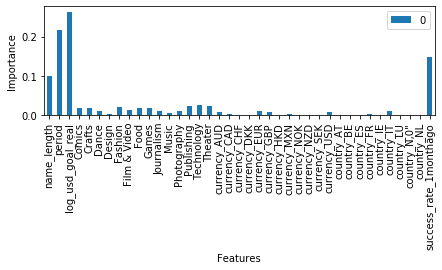

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 ...
 [53.         29.          9.39266193 ...  0.          0.
   0.27714374]
 [ 9.         59.          9.90348755 ...  0.          0.
   0.44893832]
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]] [1 0 0 ... 1 0 1]
score= 0.6760418727798664
score= 1.0
2回目:Accuracy_learning0.676
2回目:Accuracy_test1.000
3
[0.09291331 0.20889405 0.26473681 0.01772552 0.02075147 0.01386772
 0.01011321 0.01745321 0.01065056 0.02245124 0.04234632 0.0077507
 0.00682835 0.00944717 0.0208462  0.02772036 0.01526142 0.00650724
 0.01039337 0.         0.         0.01846957 0.00154924 0.
 0.01144064 0.         0.         0.         0.00714623 0.00223397
 0.         0.         0.00245839 0.         0.00477462 0.
 0.         0.         0.12526909]


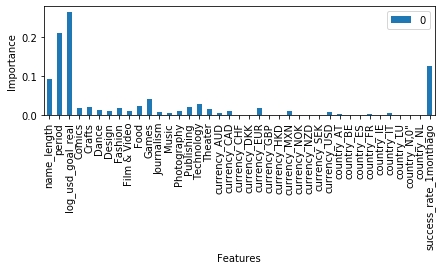

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [23.         29.         10.59663473 ...  0.          0.
   0.46312518]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 1 1 0]
score= 0.6765459667769078
score= 1.0
3回目:Accuracy_learning0.677
3回目:Accuracy_test1.000
4
[0.09055709 0.16833592 0.29795345 0.01162303 0.01764671 0.01431364
 0.00121512 0.01944729 0.02284387 0.01550391 0.02262465 0.00850125
 0.02119572 0.01242189 0.02076604 0.04494915 0.01574723 0.00100236
 0.00216743 0.         0.00330084 0.00517436 0.00994754 0.00291142
 0.01220678 0.         0.         0.         0.01852799 0.
 0.         0.00283043 0.00329797 0.         0.01124962 0.
 0.         0.         0.12173734]


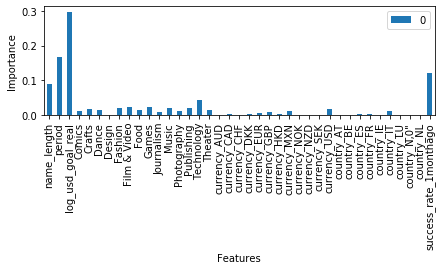

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [39.         29.          7.31322039 ...  0.          0.
   0.5095729 ]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 ...
 [55.         41.         10.30895266 ...  0.          0.
   0.33437271]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 1 1 0]
score= 0.6746960139072754
score= 1.0
4回目:Accuracy_learning0.675
4回目:Accuracy_test1.000
5
[0.10682247 0.18320665 0.24393579 0.02431127 0.01423141 0.01499245
 0.02312112 0.02217966 0.01678609 0.02781377 0.01866759 0.01107272
 0.01682473 0.01125248 0.01282027 0.04305758 0.0251523  0.00955381
 0.00189404 0.         0.         0.00857492 0.00440276 0.
 0.00840314 0.         0.         0.         0.02868489 0.
 0.         0.         0.00689472 0.         0.00425865 0.
 0.         0.         0.11108468]


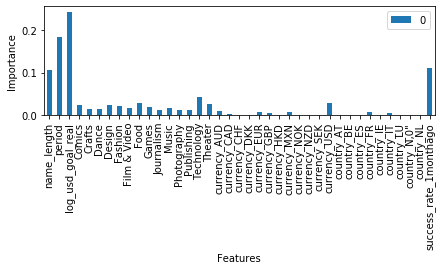

[[28.         29.          7.31322039 ...  0.          0.
   0.50803043]
 [58.         29.         10.04451348 ...  0.          0.
   0.31786543]
 [56.         30.          9.21034037 ...  0.          0.
   0.48582286]
 ...
 [ 9.         59.          9.90348755 ...  0.          0.
   0.44893832]
 [46.         32.          7.49554194 ...  0.          0.
   0.48391813]
 [42.         32.         11.51292546 ...  0.          0.
   0.3072    ]] [1 0 0 ... 0 1 0]
score= 0.6763449117368547
score= 1.0
5回目:Accuracy_learning0.676
5回目:Accuracy_test1.000
6
[0.10039079 0.16281636 0.26525648 0.02128643 0.021483   0.01580265
 0.00563576 0.02096541 0.01778174 0.02485559 0.02343154 0.01249629
 0.00646252 0.00985735 0.01617914 0.02490941 0.01507552 0.01544484
 0.0103804  0.         0.         0.01643525 0.00728136 0.
 0.00636754 0.         0.         0.00230074 0.0046845  0.
 0.         0.         0.00577931 0.         0.00315217 0.
 0.         0.         0.1634879 ]


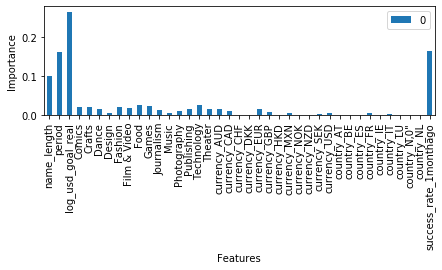

In [32]:
#⓻交差検証法を
# 決定偽モデルで
# dataB_x_train,,dataB_y_trainでおこなう

n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_score_test = 0
cross_valid_score_learning = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_index,test_index in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(dataB_x_train,dataB_y_train):
    print(dataB_x_train[train_index],dataB_y_train[train_index])
    #x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
    X_train,y_train=dataB_x_train[train_index],dataB_y_train[train_index]
    X_test,y_test=dataB_x_train[test_index],dataB_y_train[test_index]

    #データの標準化を行う※※※    
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    #plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
    X_test_stand = stdsc.transform(X_test)
    #plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

    # 学習用データを使って決定木モデルを学習
    #reg=LinearRegression(fit_intercept=True)

    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=3,
                                                     min_samples_split=3, 
                                                     random_state=1234,
                                                     criterion="gini"),
                                           n_estimators=10, random_state=1234)
    clf = clf.fit(X_train_stand, y_train)
    print("score=", clf.score(X_train_stand, y_train))

    # テストデータに対する予測を実行
    y_predict_test=clf.predict(X_test_stand)

    # テストデータに対するスコアを計算
    print("score=", clf.score(X_test_stand, y_predict_test))
    #mae=mean_absolute_error(y_test,y_predict_test)
    accuracy_test=clf.score(X_test_stand, y_predict_test)*100
    print(f"{split_num}回目:Accuracy_learning{clf.score(X_train_stand, y_train):.3f}")
    print(f"{split_num}回目:Accuracy_test{ clf.score(X_test_stand, y_predict_test):.3f}")
    #後で平均を取るためにAccuracyを加算
    cross_valid_score_learning+=clf.score(X_train_stand, y_train)
    cross_valid_score_test+=clf.score(X_test_stand, y_predict_test)
    split_num += 1
    print(split_num)

    # 説明変数の重要度を出力する
    # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
    print(clf.feature_importances_)
    pd.DataFrame(clf.feature_importances_, index=dataB.columns).plot.bar(figsize=(7,2))
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.show()
    


In [35]:
#accuracyの平均をとる
final_score_learning=cross_valid_score_learning/n_split
final_score_test=cross_valid_score_test/n_split
print(f"cross varidation accuracy:{final_score_learning:.3f}")
print(f"cross varidation accuracy:{final_score_test:.3f}")
"""
DAY2のaccuracy=0.657のため2%程の改善が見られた。
アダブーストのスコア0.67
"""

cross varidation accuracy:0.676
cross varidation accuracy:1.000


'\nランダムフォレストのスコア0.664\n'

In [36]:
"""
NN
dataB_x_test,dataB_y_test
"""
df_lr_Acc = pd.DataFrame(index=[], columns=['lr','step','loss', 'val_loss','acc', 'val_acc'])
print(df_lr_Acc)
#%%

X_train = dataB_x_train
y_train = dataB_y_train


#Adamの値を変化させる
for lr in np.arange(0.001,0.01,0.001):
     df_val_Acc = pd.DataFrame(index=[], columns=['step','loss', 'val_loss','acc', 'val_acc'])

     step=1


     for train_index, test_index in KFold(n_splits=3,
                                        shuffle=True, 
                                        random_state=1234).split(dataB_x_train, dataB_y_train):
         
         #x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]
        X_train,y_train=dataB_x_train[train_index],dataB_y_train[train_index]
        X_test,y_test=dataB_x_train[test_index],dataB_y_train[test_index]


        model = Sequential()
        model.add(Dense(6, activation='relu', input_dim=39))
        #model.add(BatchNormalization())
        model.add(Dense(5, activation='relu', input_dim=6))
        #model.add(BatchNormalization())
        model.add(Dense(2, activation='sigmoid'))#最終層のactivationは変更しないこと

        # ------ 最適化手法 ------
        #sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
        # rms = RMSprop(lr=0.01)
        # adag = Adagrad(lr=0.01)
        # adad = Adadelta(lr=0.01)
        adam = Adam(lr=lr)
        # -----------------------------

        model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

        # 計算の実行
        fit = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=20,validation_data=(X_test,y_test))

        #各epochにおける損失と精度をdfに入れる
        df = pd.DataFrame(fit.history)

        val_df = pd.DataFrame(index=[],columns=['step','loss', 'val_loss','acc', 'val_acc'])

        val_df = val_df.append(df,ignore_index = True,sort=False)

        val_df[['step']] = step

        

        df_val_Acc = df_val_Acc.append(val_df, ignore_index = True,sort=False) 

        step = step + 1

     lr_df = pd.DataFrame(index=[],columns=['lr','step','loss', 'val_loss','acc', 'val_acc'])

     lr_df = lr_df.append(df_val_Acc.mean(),ignore_index = True,sort=False)

     lr_df['lr'] = lr

     df_lr_Acc = df_lr_Acc.append(lr_df, ignore_index = True,sort=False)


display(df_lr_Acc)

df_lr_Acc[['acc', 'val_acc']].plot()

plt.show()
"""
val_accは0.001の時に最大化しているため学習率は0.001を採用する
"""


Empty DataFrame
Columns: [lr, step, loss, val_loss, acc, val_acc]
Index: []
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ValueError: Error when checking input: expected dense_input to have shape (8,) but got array with shape (39,)

Train on 265328 samples, validate on 66333 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
265328/265328 [==============================] - 4s 15us/sample - loss: 0.6373 - acc: 0.6250 - val_loss: 0.6205 - val_acc: 0.6485
Epoch 2/20
265328/265328 [==============================] - 4s 14us/sample - loss: 0.6155 - acc: 0.6551 - val_loss: 0.6179 - val_acc: 0.6499
Epoch 3/20
265328/265328 [==============================] - 4s 15us/sample - loss: 0.6136 - acc: 0.6565 - val_loss: 0.6178 - val_acc: 0.6519
Epoch 4/20
265328/265328 [==============================] - 4s 14us/sample - loss: 0.6127 - acc: 0.6571 - val_loss: 0.6146 - val_acc: 0.6529
Epoch 5/20
265328/265328 [==============================] - 4s 15us/sample - loss: 0.6124 - acc: 0.6571 - val_loss: 0.6128 - val_acc: 0.6554
Epoch 6/20
265328/265328 [==============================] - 4s 15us/sample - loss: 0.6120 - acc: 0.6579 - val_loss: 0.6130 - val_acc: 0.6551
Epoch 7/2

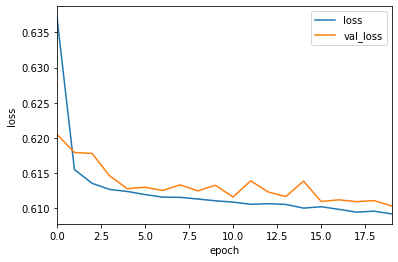

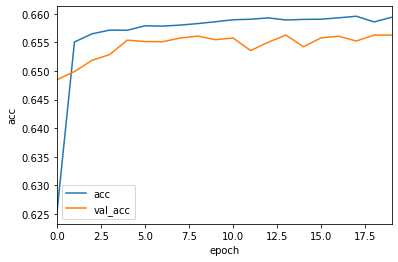

In [38]:
"""
dataB_x_test,dataB_y_test→ホールドアウト法
"""

X_train = dataB_x_train
y_train = dataB_y_train


# ------ 最適化手法 ------

adam = Adam(lr=0.001)

# -----------------------------

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=39))
#model.add(BatchNormalization())
model.add(Dense(5, activation='relu', input_dim=6))
#model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))#最終層のactivationは変更しないこと


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])



# 計算の実行

fit = model.fit(X_train, y_train,epochs=20,batch_size=256,validation_data=(dataB_x_test, dataB_y_test))



# 各epochにおける損失と精度をdfに入れる

df = pd.DataFrame(fit.history)

    

# グラフ化

df[['loss', 'val_loss']].plot()

plt.ylabel('loss')

plt.xlabel('epoch')

plt.show()



df[['acc', 'val_acc']].plot()

plt.ylabel('acc')

plt.xlabel('epoch')

plt.show()

In [39]:
display(df)

,loss,acc,val_loss,val_acc
0,0.637279,0.625004,0.620532,0.648456
1,0.615522,0.655068,0.617943,0.649888
2,0.613570,0.656497,0.617807,0.651863
3,0.612703,0.657145,0.614623,0.652873
4,0.612410,0.657111,0.612804,0.655390
5,0.611980,0.657899,0.613023,0.655149
6,0.611610,0.657846,0.612548,0.655119
7,0.611581,0.658019,0.613352,0.655752
8,0.611341,0.658287,0.612496,0.656099
9,0.611091,0.658607,0.613297,0.655466


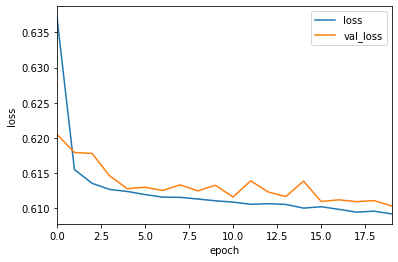

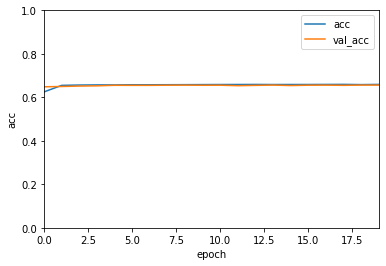

0.6566285938024521


'\nNNのスコア：0.61\n'

In [42]:
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

print(df["acc"].mean())

"""
DAY2のaccuracy=0.657のためあまり改善は見られなかった。
NNのスコア：0.6566
"""